## Imports

In [2]:
import pathlib
import sys

import centrosome.cpmorphology
import centrosome.filter
import centrosome.outline
import centrosome.zernike
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage
import scipy.signal
import skimage
import skimage.io as io
import skimage.morphology
import skimage.segmentation
from centrosome.cpmorphology import fixup_scipy_ndimage_result as fix
from scipy.linalg import lstsq

sys.path.append("../featurization")
from area_size_shape import measure_area_size_shape

## Load images

In [3]:
input_dir = pathlib.Path("../../data/NF0014/cellprofiler/C4-2/")
clip_limit = 0.03
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]
# find the cytoplasmic channels in the image set
for f in files:
    if "405" in f:
        nuclei = io.imread(f)
    elif "488" in f:
        cyto1 = io.imread(f)
    elif "555" in f:
        cyto2 = io.imread(f)
    elif "640" in f:
        cyto3 = io.imread(f)
    elif "TRANS" in f:
        brightfield = io.imread(f)
    elif "nuclei" in f:
        nuclei_mask = io.imread(f)
    elif "cell_" in f:
        cell_mask = io.imread(f)
    elif "cytoplasm" in f:
        cytoplasm_mask = io.imread(f)
    elif "organoid" in f:
        organoid_mask = io.imread(f)

    else:
        print(f"Unknown channel: {f}")

# pick which channels to use for cellpose
cyto = skimage.exposure.equalize_adapthist(cyto2, clip_limit=clip_limit)


original_nuclei_image = nuclei.copy()
original_cyto_image = cyto.copy()

original_nuclei_z_count = nuclei.shape[0]
original_cyto_z_count = cyto.shape[0]

In [4]:
print(organoid_mask.shape)

(33, 1537, 1540)


In [5]:
# get an image with only one mask


def get_image_with_mask(mask_array, mask_number):
    # get the mask for the organoid
    mask = np.zeros_like(mask_array)
    mask[mask_array == mask_number] = mask_number
    return mask


mask_object = get_image_with_mask(organoid_mask, 1)
print(mask_object.shape)
print(np.unique(mask_object))

(33, 1537, 1540)
[0 1]


In [6]:
def get_objects(mask_array):
    objects = []
    for mask in np.unique(mask_array):
        if mask == 0:
            continue
        objects.append(get_image_with_mask(mask_array, mask))
    return objects


objects_list = get_objects(organoid_mask)
print(len(objects_list))
print(objects_list[0].shape)
print(np.unique(objects_list[0]))

3
(33, 1537, 1540)
[0 1]


In [7]:
SPACING = (1.0, 0.1, 0.1)

# TODO: add func to get the spacing from the image metadata

## Notes

But also convert masks to point clouds. 


Modules to make: (from https://cellprofiler-manual.s3.amazonaws.com/CellProfiler-4.2.8/modules/measurement.html)
- Colocalization
    - Correlation
    - Slope
    - Overlap coefficient
    - Manders' coefficient
    - Manders coefficient (Costes Automated Threshold): 
    - Rank Weighted Colocalization coefficient
- Ganularity
- Intensity
    - IntegratedIntensity
    - MeanIntensity
    - StdIntensity
    - MaxIntensity
    - MinIntensity
    - IntegratedIntensityEdge
    - MeanIntensityEdge
    - StdIntensityEdge
    - MaxIntensityEdge
    - MinIntensityEdge
    - MassDisplacement
    - LowerQuartileIntensity
    - MedianIntensity
    - MADIntensity
    - UpperQuartileIntensity
    - LocationCenterMassIntensity
    - LocationMaxIntensity

- Intensity Distribution
    - FracAtD
    - MeanFac
    - RadialCV
    - Zernike
- Neighbors
    - NumberOfNeighbors
    - PercentTouching
    - FirstClosestObjectNumber
    - FirstClosestDistance
    - SecondClosestObjectNumber
    - SecondClosestDistance
    - AngleBetweenNeighbors
- SizeShape
    - Volume
    - SuraceArea
    - ConvexArea
    - Solidity
    - Extent
    - EulerNumber
    - Center coordinates
    - Bounding box
    - Bounding box volume
    - MajorAxisLength
    - MinorAxisLength
    - EquivalentDiameter
- Texture
    - AngularSecondMoment
    - Contrast
    - Correlation
    - Variance
    - InverseDifferenceMoment
    - SumAverage
    - SumVariance
    - SumEntropy
    - Entropy
    - DifferenceVariance
    - DifferenceEntropy
    - InfoMeas1
    - InfoMeas2
    

## Area Size Shape

In [10]:
measure_area_size_shape(mask_object, SPACING)

KeyboardInterrupt: 

## Colocalization

In [49]:
M_ACCURATE = "Accurate"


def linear_costes(self, fi, si, scale_max=255):
    """
    Finds the Costes Automatic Threshold for colocalization using a linear algorithm.
    Candiate thresholds are gradually decreased until Pearson R falls below 0.
    If "Fast" mode is enabled the "steps" between tested thresholds will be increased
    when Pearson R is much greater than 0.
    """
    i_step = 1 / scale_max
    non_zero = (fi > 0) | (si > 0)
    xvar = numpy.var(fi[non_zero], axis=0, ddof=1)
    yvar = numpy.var(si[non_zero], axis=0, ddof=1)

    xmean = numpy.mean(fi[non_zero], axis=0)
    ymean = numpy.mean(si[non_zero], axis=0)

    z = fi[non_zero] + si[non_zero]
    zvar = numpy.var(z, axis=0, ddof=1)

    covar = 0.5 * (zvar - (xvar + yvar))

    denom = 2 * covar
    num = (yvar - xvar) + numpy.sqrt(
        (yvar - xvar) * (yvar - xvar) + 4 * (covar * covar)
    )
    a = num / denom
    b = ymean - a * xmean

    # Start at 1 step above the maximum value
    img_max = max(fi.max(), si.max())
    i = i_step * ((img_max // i_step) + 1)

    num_true = None
    fi_max = fi.max()
    si_max = si.max()

    # Initialise without a threshold
    costReg, _ = scipy.stats.pearsonr(fi, si)
    thr_fi_c = i
    thr_si_c = (a * i) + b
    while i > fi_max and (a * i) + b > si_max:
        i -= i_step
    while i > i_step:
        thr_fi_c = i
        thr_si_c = (a * i) + b
        combt = (fi < thr_fi_c) | (si < thr_si_c)
        try:
            # Only run pearsonr if the input has changed.
            if (positives := numpy.count_nonzero(combt)) != num_true:
                costReg, _ = scipy.stats.pearsonr(fi[combt], si[combt])
                num_true = positives

            if costReg <= 0:
                break
            elif self.fast_costes.value == M_ACCURATE or i < i_step * 10:
                i -= i_step
            elif costReg > 0.45:
                # We're way off, step down 10x
                i -= i_step * 10
            elif costReg > 0.35:
                # Still far from 0, step 5x
                i -= i_step * 5
            elif costReg > 0.25:
                # Step 2x
                i -= i_step * 2
            else:
                i -= i_step
        except ValueError:
            break
    return thr_fi_c, thr_si_c


def bisection_costes(self, fi, si, scale_max=255):
    """
    Finds the Costes Automatic Threshold for colocalization using a bisection algorithm.
    Candidate thresholds are selected from within a window of possible intensities,
    this window is narrowed based on the R value of each tested candidate.
    We're looking for the first point below 0, and R value can become highly variable
    at lower thresholds in some samples. Therefore the candidate tested in each
    loop is 1/6th of the window size below the maximum value (as opposed to the midpoint).
    """

    non_zero = (fi > 0) | (si > 0)
    xvar = numpy.var(fi[non_zero], axis=0, ddof=1)
    yvar = numpy.var(si[non_zero], axis=0, ddof=1)

    xmean = numpy.mean(fi[non_zero], axis=0)
    ymean = numpy.mean(si[non_zero], axis=0)

    z = fi[non_zero] + si[non_zero]
    zvar = numpy.var(z, axis=0, ddof=1)

    covar = 0.5 * (zvar - (xvar + yvar))

    denom = 2 * covar
    num = (yvar - xvar) + numpy.sqrt(
        (yvar - xvar) * (yvar - xvar) + 4 * (covar * covar)
    )
    a = num / denom
    b = ymean - a * xmean

    # Initialise variables
    left = 1
    right = scale_max
    mid = ((right - left) // (6 / 5)) + left
    lastmid = 0
    # Marks the value with the last positive R value.
    valid = 1

    while lastmid != mid:
        thr_fi_c = mid / scale_max
        thr_si_c = (a * thr_fi_c) + b
        combt = (fi < thr_fi_c) | (si < thr_si_c)
        if numpy.count_nonzero(combt) <= 2:
            # Can't run pearson with only 2 values.
            left = mid - 1
        else:
            try:
                costReg, _ = scipy.stats.pearsonr(fi[combt], si[combt])
                if costReg < 0:
                    left = mid - 1
                elif costReg >= 0:
                    right = mid + 1
                    valid = mid
            except ValueError:
                # Catch misc Pearson errors with low sample numbers
                left = mid - 1
        lastmid = mid
        if right - left > 6:
            mid = ((right - left) // (6 / 5)) + left
        else:
            mid = ((right - left) // 2) + left

    thr_fi_c = (valid - 1) / scale_max
    thr_si_c = (a * thr_fi_c) + b

    return thr_fi_c, thr_si_c

In [50]:
"""Feature name format for the correlation measurement"""
F_CORRELATION_FORMAT = "Correlation_Correlation_%s_%s"

"""Feature name format for the slope measurement"""
F_SLOPE_FORMAT = "Correlation_Slope_%s_%s"

"""Feature name format for the overlap coefficient measurement"""
F_OVERLAP_FORMAT = "Correlation_Overlap_%s_%s"

"""Feature name format for the Manders Coefficient measurement"""
F_K_FORMAT = "Correlation_K_%s_%s"

"""Feature name format for the Manders Coefficient measurement"""
F_KS_FORMAT = "Correlation_KS_%s_%s"

"""Feature name format for the Manders Coefficient measurement"""
F_MANDERS_FORMAT = "Correlation_Manders_%s_%s"

"""Feature name format for the RWC Coefficient measurement"""
F_RWC_FORMAT = "Correlation_RWC_%s_%s"

"""Feature name format for the Costes Coefficient measurement"""
F_COSTES_FORMAT = "Correlation_Costes_%s_%s"

In [ ]:
# TODO: add an individual object retrieval function for colocalization analysis

## Granularity

In [1]:
C_GRANULARITY = "Granularity_%s_%s"

IMAGE_SETTING_COUNT_V2 = 5
IMAGE_SETTING_COUNT_V3 = 6
IMAGE_SETTING_COUNT = IMAGE_SETTING_COUNT_V3

OBJECTS_SETTING_COUNT_V3 = 1
OBJECTS_SETTING_COUNT = OBJECTS_SETTING_COUNT_V3


def granularity_feature(self, length, image_name):
    return C_GRANULARITY % (length, image_name)

In [ ]:
def measure_granularity(
    image, image_name, radius: int = 10, granular_spectrum_length: int = 10
):

    #
    # Downsample the image and mask
    #
    new_shape = numpy.array(image.shape)
    pixels = image.copy()
    mask = image.copy()

    back_pixels = pixels
    back_mask = mask
    back_shape = new_shape

    footprint = skimage.morphology.ball(radius, dtype=bool)
    back_pixels_mask = numpy.zeros_like(back_pixels)
    back_pixels_mask[back_mask == True] = back_pixels[back_mask == True]
    back_pixels = skimage.morphology.erosion(back_pixels_mask, footprint=footprint)
    back_pixels_mask = numpy.zeros_like(back_pixels)
    back_pixels_mask[back_mask == True] = back_pixels[back_mask == True]
    back_pixels = skimage.morphology.dilation(back_pixels_mask, footprint=footprint)
    pixels -= back_pixels
    pixels[pixels < 0] = 0
    startmean = numpy.mean(pixels[mask])
    ero = pixels.copy()
    # Mask the test image so that masked pixels will have no effect
    # during reconstruction
    #
    ero[~mask] = 0
    currentmean = startmean
    startmean = max(startmean, numpy.finfo(float).eps)
    footprint = skimage.morphology.ball(1, dtype=bool)
    statistics = [image_name]
    for i in range(1, granular_spectrum_length + 1):
        prevmean = currentmean
        ero_mask = numpy.zeros_like(ero)
        ero_mask[mask == True] = ero[mask == True]
        ero = skimage.morphology.erosion(ero_mask, footprint=footprint)
        rec = skimage.morphology.reconstruction(ero, pixels, footprint=footprint)
        currentmean = numpy.mean(rec[mask])
        gs = (prevmean - currentmean) * 100 / startmean
        statistics += ["%.2f" % gs]
        feature = granularity_feature(i, image_name)
        #
        # Restore the reconstructed image to the shape of the
        # original image so we can match against object labels
        #
        orig_shape = image.pixel_data.shape
        k, i, j = numpy.mgrid[
            0 : orig_shape[0], 0 : orig_shape[1], 0 : orig_shape[2]
        ].astype(float)
        k *= float(new_shape[0] - 1) / float(orig_shape[0] - 1)
        i *= float(new_shape[1] - 1) / float(orig_shape[1] - 1)
        j *= float(new_shape[2] - 1) / float(orig_shape[2] - 1)
        rec = scipy.ndimage.map_coordinates(rec, (k, i, j), order=1)
    return statistics


measure_granularity(organoid_mask, "organoid_mask")

## Intensity

Mesurments to make:
- integrated_intensity 
- integrated_intensity_edge 
- mean_intensity 
- mean_intensity_edge 
- std_intensity 
- std_intensity_edge 
- min_intensity 
- min_intensity_edge 
- max_intensity 
- max_intensity_edge 
- mass_displacement 
- lower_quartile_intensity 
- median_intensity
- mad_intensity 
- upper_quartile_intensity 
- cmi_x 
- cmi_y 
- cmi_z 
- max_x 
- max_y 
- max_z 

In [13]:
import numpy

In [23]:
image_object = cyto3
image_object.shape
image_shape = image_object.shape

In [ ]:
# function that gets the outline of the mask


def get_outline(mask):
    outline = numpy.zeros_like(mask)
    for z in range(mask.shape[0]):
        outline[z] = skimage.segmentation.find_boundaries(mask[z])
    return outline

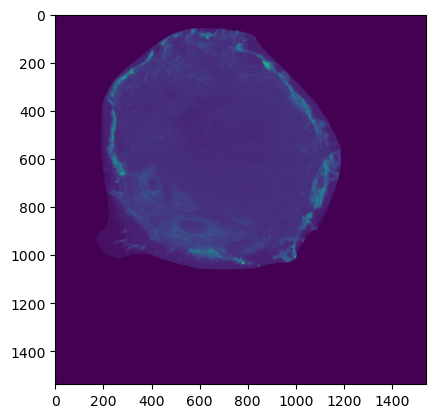

In [78]:
mask_object
image_object = cyto1
mesh_z, mesh_y, mesh_x = numpy.mgrid[
    0 : image_object.shape[0],
    0 : image_object.shape[1],
    0 : image_object.shape[2],
]

# set all image pixels to 0 if not in mask
image_object[mask_object == 0] = 0
non_zero_pixels_object = image_object[image_object > 0]
mask_outlines = get_outline(mask_object)
# mesh_x = mesh_x[mask_object > 0]
# mesh_y = mesh_y[mask_object > 0]
# mesh_z = mesh_z[mask_object > 0]
plt.imshow(image_object[0])
plt.show()

In [89]:
def measure_3D_intensity(image_object, mask_object):

    non_zero_pixels_object = image_object[image_object > 0]
    mask_outlines = get_outline(mask_object)

    # calculate the integrated intensity
    integrated_intensity = numpy.sum(image_object)
    # calculate the volume
    volume = numpy.sum(mask_object)
    # calculate the mean intensity
    mean_intensity = integrated_intensity / volume
    # calculate the standard deviation
    std_intensity = numpy.std(non_zero_pixels_object)
    # min intensity
    min_intensity = numpy.min(non_zero_pixels_object)
    # max intensity
    max_intensity = numpy.max(non_zero_pixels_object)
    # lower quartile
    lower_quartile_intensity = numpy.percentile(non_zero_pixels_object, 25)
    # upper quartile
    upper_quartile_intensity = numpy.percentile(non_zero_pixels_object, 75)
    # median intensity
    median_intensity = numpy.median(non_zero_pixels_object)
    # max intensity location
    max_z, max_y, max_x = scipy.ndimage.maximum_position(
        image_object,
    )  # z, y, x
    cm_x = scipy.ndimage.mean(mesh_x)
    cm_y = scipy.ndimage.mean(mesh_y)
    cm_z = scipy.ndimage.mean(mesh_z)
    i_x = scipy.ndimage.sum(mesh_x)
    i_y = scipy.ndimage.sum(mesh_y)
    i_z = scipy.ndimage.sum(mesh_z)
    # calculate the center of mass
    cmi_x = i_x / integrated_intensity
    cmi_y = i_y / integrated_intensity
    cmi_z = i_z / integrated_intensity
    # calculate the center of mass distance
    diff_x = cm_x - cmi_x
    diff_y = cm_y - cmi_y
    diff_z = cm_z - cmi_z
    # mass displacement
    mass_displacement = numpy.sqrt(diff_x**2 + diff_y**2 + diff_z**2)
    # mean aboslute deviation
    mad_intensity = numpy.mean(numpy.abs(non_zero_pixels_object - mean_intensity))
    edge_count = scipy.ndimage.sum(mask_outlines)
    integrated_intensity_edge = numpy.sum(image_object[mask_outlines > 0])
    mean_intensity_edge = integrated_intensity_edge / edge_count
    std_intensity_edge = numpy.std(image_object[mask_outlines > 0])
    min_intensity_edge = numpy.min(image_object[mask_outlines > 0])
    max_intensity_edge = numpy.max(image_object[mask_outlines > 0])

    return {
        "integrated_intensity": integrated_intensity,
        "volume": volume,
        "mean_intensity": mean_intensity,
        "std_intensity": std_intensity,
        "min_intensity": min_intensity,
        "max_intensity": max_intensity,
        "lower_quartile_intensity": lower_quartile_intensity,
        "upper_quartile_intensity": upper_quartile_intensity,
        "median_intensity": median_intensity,
        "max_z": max_z,
        "max_y": max_y,
        "max_x": max_x,
        "cm_x": cm_x,
        "cm_y": cm_y,
        "cm_z": cm_z,
        "i_x": i_x,
        "i_y": i_y,
        "i_z": i_z,
        "cmi_x": cmi_x,
        "cmi_y": cmi_y,
        "cmi_z": cmi_z,
        "diff_x": diff_x,
        "diff_y": diff_y,
        "diff_z": diff_z,
        "mass_displacement": mass_displacement,
        "mad_intensity": mad_intensity,
        "edge_count": edge_count,
        "integrated_intensity_edge": integrated_intensity_edge,
        "mean_intensity_edge": mean_intensity_edge,
        "std_intensity_edge": std_intensity_edge,
        "min_intensity_edge": min_intensity_edge,
        "max_intensity_edge": max_intensity_edge,
    }

$$MAD = \frac{\sum{|{x_i - \bar{x} |}}}{n}$$

In [92]:
integrated_intensity
mean_intensity
std_intensity
min_intensity
max_intensity
integrated_intensity_edge
mean_intensity_edge
std_intensity_edge
min_intensity_edge
max_intensity_edge
mass_displacement
lower_quartile_intensity
median_intensity
mad_intensity
upper_quartile_intensity
cmi_x
cmi_y
cmi_z
max_x
max_y
max_z

4

## Neighbors

In [ ]:
def run(self, workspace):
    objects = workspace.object_set.get_objects(self.object_name.value)
    dimensions = len(objects.shape)
    assert isinstance(objects, Objects)
    has_pixels = objects.areas > 0
    labels = objects.small_removed_segmented
    kept_labels = objects.segmented
    neighbor_objects = workspace.object_set.get_objects(self.neighbors_name.value)
    neighbor_labels = neighbor_objects.small_removed_segmented
    neighbor_kept_labels = neighbor_objects.segmented
    assert isinstance(neighbor_objects, Objects)
    if not self.wants_excluded_objects.value:
        # Remove labels not present in kept segmentation while preserving object IDs.
        mask = neighbor_kept_labels > 0
        neighbor_labels[~mask] = 0
    nobjects = numpy.max(labels)
    nkept_objects = len(objects.indices)
    nneighbors = numpy.max(neighbor_labels)

    _, object_numbers = objects.relate_labels(labels, kept_labels)
    if self.neighbors_are_objects:
        neighbor_numbers = object_numbers
        neighbor_has_pixels = has_pixels
    else:
        _, neighbor_numbers = neighbor_objects.relate_labels(
            neighbor_labels, neighbor_kept_labels
        )
        neighbor_has_pixels = numpy.bincount(neighbor_kept_labels.ravel())[1:] > 0
    neighbor_count = numpy.zeros((nobjects,))
    pixel_count = numpy.zeros((nobjects,))
    first_object_number = numpy.zeros((nobjects,), int)
    second_object_number = numpy.zeros((nobjects,), int)
    first_x_vector = numpy.zeros((nobjects,))
    second_x_vector = numpy.zeros((nobjects,))
    first_y_vector = numpy.zeros((nobjects,))
    second_y_vector = numpy.zeros((nobjects,))
    angle = numpy.zeros((nobjects,))
    percent_touching = numpy.zeros((nobjects,))
    expanded_labels = None
    if self.distance_method == D_EXPAND:
        # Find the i,j coordinates of the nearest foreground point
        # to every background point
        if dimensions == 2:
            i, j = scipy.ndimage.distance_transform_edt(
                labels == 0, return_distances=False, return_indices=True
            )
            # Assign each background pixel to the label of its nearest
            # foreground pixel. Assign label to label for foreground.
            labels = labels[i, j]
        else:
            k, i, j = scipy.ndimage.distance_transform_edt(
                labels == 0, return_distances=False, return_indices=True
            )
            labels = labels[k, i, j]
        expanded_labels = labels  # for display
        distance = 1  # dilate once to make touching edges overlap
        scale = S_EXPANDED
        if self.neighbors_are_objects:
            neighbor_labels = labels.copy()
    elif self.distance_method == D_WITHIN:
        distance = self.distance.value
        scale = str(distance)
    elif self.distance_method == D_ADJACENT:
        distance = 1
        scale = S_ADJACENT
    else:
        raise ValueError("Unknown distance method: %s" % self.distance_method.value)
    if nneighbors > (1 if self.neighbors_are_objects else 0):
        first_objects = []
        second_objects = []
        object_indexes = numpy.arange(nobjects, dtype=numpy.int32) + 1
        #
        # First, compute the first and second nearest neighbors,
        # and the angles between self and the first and second
        # nearest neighbors
        #
        ocenters = centers_of_labels(objects.small_removed_segmented).transpose()
        ncenters = centers_of_labels(
            neighbor_objects.small_removed_segmented
        ).transpose()
        areas = fix(scipy.ndimage.sum(numpy.ones(labels.shape), labels, object_indexes))
        perimeter_outlines = outline(labels)
        perimeters = fix(
            scipy.ndimage.sum(
                numpy.ones(labels.shape), perimeter_outlines, object_indexes
            )
        )

        #
        # order[:,0] should be arange(nobjects)
        # order[:,1] should be the nearest neighbor
        # order[:,2] should be the next nearest neighbor
        #
        order = numpy.zeros((nobjects, min(nneighbors, 3)), dtype=numpy.uint32)
        j = numpy.arange(nneighbors)
        # (0, 1, 2) unless there are less than 3 neighbors
        partition_keys = tuple(range(min(nneighbors, 3)))
        for i in range(nobjects):
            dr = numpy.sqrt(
                (ocenters[i, 0] - ncenters[j, 0]) ** 2
                + (ocenters[i, 1] - ncenters[j, 1]) ** 2
            )
            order[i, :] = numpy.argpartition(dr, partition_keys)[:3]

        first_neighbor = 1 if self.neighbors_are_objects else 0
        first_object_index = order[:, first_neighbor]
        first_x_vector = ncenters[first_object_index, 1] - ocenters[:, 1]
        first_y_vector = ncenters[first_object_index, 0] - ocenters[:, 0]
        if nneighbors > first_neighbor + 1:
            second_object_index = order[:, first_neighbor + 1]
            second_x_vector = ncenters[second_object_index, 1] - ocenters[:, 1]
            second_y_vector = ncenters[second_object_index, 0] - ocenters[:, 0]
            v1 = numpy.array((first_x_vector, first_y_vector))
            v2 = numpy.array((second_x_vector, second_y_vector))
            #
            # Project the unit vector v1 against the unit vector v2
            #
            dot = numpy.sum(v1 * v2, 0) / numpy.sqrt(
                numpy.sum(v1**2, 0) * numpy.sum(v2**2, 0)
            )
            angle = numpy.arccos(dot) * 180.0 / numpy.pi

        # Make the structuring element for dilation
        if dimensions == 2:
            strel = strel_disk(distance)
        else:
            strel = skimage.morphology.ball(distance)
        #
        # A little bigger one to enter into the border with a structure
        # that mimics the one used to create the outline
        #
        if dimensions == 2:
            strel_touching = strel_disk(distance + 0.5)
        else:
            strel_touching = skimage.morphology.ball(distance + 0.5)
        #
        # Get the extents for each object and calculate the patch
        # that excises the part of the image that is "distance"
        # away
        if dimensions == 2:
            i, j = numpy.mgrid[0 : labels.shape[0], 0 : labels.shape[1]]

            minimums_i, maximums_i, _, _ = scipy.ndimage.extrema(
                i, labels, object_indexes
            )
            minimums_j, maximums_j, _, _ = scipy.ndimage.extrema(
                j, labels, object_indexes
            )

            minimums_i = numpy.maximum(fix(minimums_i) - distance, 0).astype(int)
            maximums_i = numpy.minimum(
                fix(maximums_i) + distance + 1, labels.shape[0]
            ).astype(int)
            minimums_j = numpy.maximum(fix(minimums_j) - distance, 0).astype(int)
            maximums_j = numpy.minimum(
                fix(maximums_j) + distance + 1, labels.shape[1]
            ).astype(int)
        else:
            k, i, j = numpy.mgrid[
                0 : labels.shape[0], 0 : labels.shape[1], 0 : labels.shape[2]
            ]

            minimums_k, maximums_k, _, _ = scipy.ndimage.extrema(
                k, labels, object_indexes
            )
            minimums_i, maximums_i, _, _ = scipy.ndimage.extrema(
                i, labels, object_indexes
            )
            minimums_j, maximums_j, _, _ = scipy.ndimage.extrema(
                j, labels, object_indexes
            )

            minimums_k = numpy.maximum(fix(minimums_k) - distance, 0).astype(int)
            maximums_k = numpy.minimum(
                fix(maximums_k) + distance + 1, labels.shape[0]
            ).astype(int)
            minimums_i = numpy.maximum(fix(minimums_i) - distance, 0).astype(int)
            maximums_i = numpy.minimum(
                fix(maximums_i) + distance + 1, labels.shape[1]
            ).astype(int)
            minimums_j = numpy.maximum(fix(minimums_j) - distance, 0).astype(int)
            maximums_j = numpy.minimum(
                fix(maximums_j) + distance + 1, labels.shape[2]
            ).astype(int)
        #
        # Loop over all objects
        # Calculate which ones overlap "index"
        # Calculate how much overlap there is of others to "index"
        #
        for object_number in object_numbers:
            if object_number == 0:
                #
                # No corresponding object in small-removed. This means
                # that the object has no pixels, e.g., not renumbered.
                #
                continue
            index = object_number - 1
            if dimensions == 2:
                patch = labels[
                    minimums_i[index] : maximums_i[index],
                    minimums_j[index] : maximums_j[index],
                ]
                npatch = neighbor_labels[
                    minimums_i[index] : maximums_i[index],
                    minimums_j[index] : maximums_j[index],
                ]
            else:
                patch = labels[
                    minimums_k[index] : maximums_k[index],
                    minimums_i[index] : maximums_i[index],
                    minimums_j[index] : maximums_j[index],
                ]
                npatch = neighbor_labels[
                    minimums_k[index] : maximums_k[index],
                    minimums_i[index] : maximums_i[index],
                    minimums_j[index] : maximums_j[index],
                ]

            #
            # Find the neighbors
            #
            patch_mask = patch == (index + 1)
            if distance <= 5:
                extended = scipy.ndimage.binary_dilation(patch_mask, strel)
            else:
                extended = (
                    scipy.signal.fftconvolve(patch_mask, strel, mode="same") > 0.5
                )
            neighbors = numpy.unique(npatch[extended])
            neighbors = neighbors[neighbors != 0]
            if self.neighbors_are_objects:
                neighbors = neighbors[neighbors != object_number]
            nc = len(neighbors)
            neighbor_count[index] = nc
            if nc > 0:
                first_objects.append(numpy.ones(nc, int) * object_number)
                second_objects.append(neighbors)
            #
            # Find the # of overlapping pixels. Dilate the neighbors
            # and see how many pixels overlap our image. Use a 3x3
            # structuring element to expand the overlapping edge
            # into the perimeter.
            #
            if dimensions == 2:
                outline_patch = (
                    perimeter_outlines[
                        minimums_i[index] : maximums_i[index],
                        minimums_j[index] : maximums_j[index],
                    ]
                    == object_number
                )
            else:
                outline_patch = (
                    perimeter_outlines[
                        minimums_k[index] : maximums_k[index],
                        minimums_i[index] : maximums_i[index],
                        minimums_j[index] : maximums_j[index],
                    ]
                    == object_number
                )
            if self.neighbors_are_objects:
                extendme = (patch != 0) & (patch != object_number)
                if distance <= 5:
                    extended = scipy.ndimage.binary_dilation(extendme, strel_touching)
                else:
                    extended = (
                        scipy.signal.fftconvolve(extendme, strel_touching, mode="same")
                        > 0.5
                    )
            else:
                if distance <= 5:
                    extended = scipy.ndimage.binary_dilation(
                        (npatch != 0), strel_touching
                    )
                else:
                    extended = (
                        scipy.signal.fftconvolve(
                            (npatch != 0), strel_touching, mode="same"
                        )
                        > 0.5
                    )
            overlap = numpy.sum(outline_patch & extended)
            pixel_count[index] = overlap
        if sum([len(x) for x in first_objects]) > 0:
            first_objects = numpy.hstack(first_objects)
            reverse_object_numbers = numpy.zeros(
                max(numpy.max(object_numbers), numpy.max(first_objects)) + 1, int
            )
            reverse_object_numbers[object_numbers] = (
                numpy.arange(len(object_numbers)) + 1
            )
            first_objects = reverse_object_numbers[first_objects]

            second_objects = numpy.hstack(second_objects)
            reverse_neighbor_numbers = numpy.zeros(
                max(numpy.max(neighbor_numbers), numpy.max(second_objects)) + 1, int
            )
            reverse_neighbor_numbers[neighbor_numbers] = (
                numpy.arange(len(neighbor_numbers)) + 1
            )
            second_objects = reverse_neighbor_numbers[second_objects]
            to_keep = (first_objects > 0) & (second_objects > 0)
            first_objects = first_objects[to_keep]
            second_objects = second_objects[to_keep]
        else:
            first_objects = numpy.zeros(0, int)
            second_objects = numpy.zeros(0, int)
        percent_touching = pixel_count * 100 / perimeters
        object_indexes = object_numbers - 1
        neighbor_indexes = neighbor_numbers - 1
        #
        # Have to recompute nearest
        #
        first_object_number = numpy.zeros(nkept_objects, int)
        second_object_number = numpy.zeros(nkept_objects, int)
        if nkept_objects > (1 if self.neighbors_are_objects else 0):
            di = (
                ocenters[object_indexes[:, numpy.newaxis], 0]
                - ncenters[neighbor_indexes[numpy.newaxis, :], 0]
            )
            dj = (
                ocenters[object_indexes[:, numpy.newaxis], 1]
                - ncenters[neighbor_indexes[numpy.newaxis, :], 1]
            )
            distance_matrix = numpy.sqrt(di * di + dj * dj)
            distance_matrix[~has_pixels, :] = numpy.inf
            distance_matrix[:, ~neighbor_has_pixels] = numpy.inf
            #
            # order[:,0] should be arange(nobjects)
            # order[:,1] should be the nearest neighbor
            # order[:,2] should be the next nearest neighbor
            #
            order = numpy.lexsort([distance_matrix]).astype(first_object_number.dtype)
            if self.neighbors_are_objects:
                first_object_number[has_pixels] = order[has_pixels, 1] + 1
                if nkept_objects > 2:
                    second_object_number[has_pixels] = order[has_pixels, 2] + 1
            else:
                first_object_number[has_pixels] = order[has_pixels, 0] + 1
                if order.shape[1] > 1:
                    second_object_number[has_pixels] = order[has_pixels, 1] + 1
    else:
        object_indexes = object_numbers - 1
        neighbor_indexes = neighbor_numbers - 1
        first_objects = numpy.zeros(0, int)
        second_objects = numpy.zeros(0, int)
    #
    # Now convert all measurements from the small-removed to
    # the final number set.
    #
    neighbor_count = neighbor_count[object_indexes]
    neighbor_count[~has_pixels] = 0
    percent_touching = percent_touching[object_indexes]
    percent_touching[~has_pixels] = 0
    first_x_vector = first_x_vector[object_indexes]
    second_x_vector = second_x_vector[object_indexes]
    first_y_vector = first_y_vector[object_indexes]
    second_y_vector = second_y_vector[object_indexes]
    angle = angle[object_indexes]
    #
    # Record the measurements
    #
    assert isinstance(workspace, Workspace)
    m = workspace.measurements
    assert isinstance(m, Measurements)
    image_set = workspace.image_set
    features_and_data = [
        (M_NUMBER_OF_NEIGHBORS, neighbor_count),
        (M_FIRST_CLOSEST_OBJECT_NUMBER, first_object_number),
        (
            M_FIRST_CLOSEST_DISTANCE,
            numpy.sqrt(first_x_vector**2 + first_y_vector**2),
        ),
        (M_SECOND_CLOSEST_OBJECT_NUMBER, second_object_number),
        (
            M_SECOND_CLOSEST_DISTANCE,
            numpy.sqrt(second_x_vector**2 + second_y_vector**2),
        ),
        (M_ANGLE_BETWEEN_NEIGHBORS, angle),
        (M_PERCENT_TOUCHING, percent_touching),
    ]
    for feature_name, data in features_and_data:
        m.add_measurement(
            self.object_name.value, self.get_measurement_name(feature_name), data
        )
    if len(first_objects) > 0:
        m.add_relate_measurement(
            self.module_num,
            NEIGHBORS,
            self.object_name.value,
            self.object_name.value
            if self.neighbors_are_objects
            else self.neighbors_name.value,
            m.image_set_number * numpy.ones(first_objects.shape, int),
            first_objects,
            m.image_set_number * numpy.ones(second_objects.shape, int),
            second_objects,
        )

    labels = kept_labels
    neighbor_labels = neighbor_kept_labels

    neighbor_count_image = numpy.zeros(labels.shape, int)
    object_mask = objects.segmented != 0
    object_indexes = objects.segmented[object_mask] - 1
    neighbor_count_image[object_mask] = neighbor_count[object_indexes]
    workspace.display_data.neighbor_count_image = neighbor_count_image

    percent_touching_image = numpy.zeros(labels.shape)
    percent_touching_image[object_mask] = percent_touching[object_indexes]
    workspace.display_data.percent_touching_image = percent_touching_image

    image_set = workspace.image_set
    if self.wants_count_image.value:
        neighbor_cm_name = self.count_colormap.value
        neighbor_cm = get_colormap(neighbor_cm_name)
        sm = matplotlib.cm.ScalarMappable(cmap=neighbor_cm)
        img = sm.to_rgba(neighbor_count_image)[:, :, :3]
        img[:, :, 0][~object_mask] = 0
        img[:, :, 1][~object_mask] = 0
        img[:, :, 2][~object_mask] = 0
        count_image = Image(img, masking_objects=objects)
        image_set.add(self.count_image_name.value, count_image)
    else:
        neighbor_cm_name = "Blues"
        neighbor_cm = matplotlib.cm.get_cmap(neighbor_cm_name)
    if self.wants_percent_touching_image:
        percent_touching_cm_name = self.touching_colormap.value
        percent_touching_cm = get_colormap(percent_touching_cm_name)
        sm = matplotlib.cm.ScalarMappable(cmap=percent_touching_cm)
        img = sm.to_rgba(percent_touching_image)[:, :, :3]
        img[:, :, 0][~object_mask] = 0
        img[:, :, 1][~object_mask] = 0
        img[:, :, 2][~object_mask] = 0
        touching_image = Image(img, masking_objects=objects)
        image_set.add(self.touching_image_name.value, touching_image)
    else:
        percent_touching_cm_name = "Oranges"
        percent_touching_cm = matplotlib.cm.get_cmap(percent_touching_cm_name)

    if self.show_window:
        workspace.display_data.neighbor_cm_name = neighbor_cm_name
        workspace.display_data.percent_touching_cm_name = percent_touching_cm_name
        workspace.display_data.orig_labels = objects.segmented
        workspace.display_data.neighbor_labels = neighbor_labels
        workspace.display_data.expanded_labels = expanded_labels
        workspace.display_data.object_mask = object_mask
        workspace.display_data.dimensions = dimensions

In [ ]:
from functools import reduce

import centrosome.cpmorphology
import centrosome.fastemd
import centrosome.filter
import centrosome.index
import centrosome.propagate

In [ ]:
C_IMAGE_OVERLAP = "Overlap"
FTR_F_FACTOR = "Ffactor"
FTR_PRECISION = "Precision"
FTR_RECALL = "Recall"
FTR_TRUE_POS_RATE = "TruePosRate"
FTR_FALSE_POS_RATE = "FalsePosRate"
FTR_FALSE_NEG_RATE = "FalseNegRate"
FTR_TRUE_NEG_RATE = "TrueNegRate"
FTR_RAND_INDEX = "RandIndex"
FTR_ADJUSTED_RAND_INDEX = "AdjustedRandIndex"
FTR_EARTH_MOVERS_DISTANCE = "EarthMoversDistance"

FTR_ALL = [
    FTR_F_FACTOR,
    FTR_PRECISION,
    FTR_RECALL,
    FTR_TRUE_POS_RATE,
    FTR_TRUE_NEG_RATE,
    FTR_FALSE_POS_RATE,
    FTR_FALSE_NEG_RATE,
    FTR_RAND_INDEX,
    FTR_ADJUSTED_RAND_INDEX,
]

O_OBJ = "Segmented objects"

L_LOAD = "Loaded from a previous run"
L_CP = "From this CP pipeline"

DM_KMEANS = "K Means"
DM_SKEL = "Skeleton"


def run(self, workspace):
    object_name_GT = self.object_name_GT.value
    objects_GT = workspace.get_objects(object_name_GT)
    iGT, jGT, lGT = objects_GT.ijv.transpose()
    object_name_ID = self.object_name_ID.value
    objects_ID = workspace.get_objects(object_name_ID)
    iID, jID, lID = objects_ID.ijv.transpose()
    ID_obj = 0 if len(lID) == 0 else max(lID)
    GT_obj = 0 if len(lGT) == 0 else max(lGT)

    xGT, yGT = objects_GT.shape
    xID, yID = objects_ID.shape
    GT_pixels = numpy.zeros((xGT, yGT))
    ID_pixels = numpy.zeros((xID, yID))
    total_pixels = xGT * yGT

    GT_pixels[iGT, jGT] = 1
    ID_pixels[iID, jID] = 1

    GT_tot_area = len(iGT)
    if len(iGT) == 0 and len(iID) == 0:
        intersect_matrix = numpy.zeros((0, 0), int)
    else:
        #
        # Build a matrix with rows of i, j, label and a GT/ID flag
        #
        all_ijv = numpy.column_stack(
            (
                numpy.hstack((iGT, iID)),
                numpy.hstack((jGT, jID)),
                numpy.hstack((lGT, lID)),
                numpy.hstack((numpy.zeros(len(iGT)), numpy.ones(len(iID)))),
            )
        )
        #
        # Order it so that runs of the same i, j are consecutive
        #
        order = numpy.lexsort((all_ijv[:, -1], all_ijv[:, 0], all_ijv[:, 1]))
        all_ijv = all_ijv[order, :]
        # Mark the first at each i, j != previous i, j
        first = numpy.where(
            numpy.hstack(
                ([True], ~numpy.all(all_ijv[:-1, :2] == all_ijv[1:, :2], 1), [True])
            )
        )[0]
        # Count # at each i, j
        count = first[1:] - first[:-1]
        # First indexer - mapping from i,j to index in all_ijv
        all_ijv_map = centrosome.index.Indexes([count])
        # Bincount to get the # of ID pixels per i,j
        id_count = numpy.bincount(all_ijv_map.rev_idx, all_ijv[:, -1]).astype(int)
        gt_count = count - id_count
        # Now we can create an indexer that has NxM elements per i,j
        # where N is the number of GT pixels at that i,j and M is
        # the number of ID pixels. We can then use the indexer to pull
        # out the label values for each to populate a sparse array.
        #
        cross_map = centrosome.index.Indexes([id_count, gt_count])
        off_gt = all_ijv_map.fwd_idx[cross_map.rev_idx] + cross_map.idx[0]
        off_id = (
            all_ijv_map.fwd_idx[cross_map.rev_idx]
            + cross_map.idx[1]
            + id_count[cross_map.rev_idx]
        )
        intersect_matrix = scipy.sparse.coo_matrix(
            (numpy.ones(len(off_gt)), (all_ijv[off_id, 2], all_ijv[off_gt, 2])),
            shape=(ID_obj + 1, GT_obj + 1),
        ).toarray()[1:, 1:]

    gt_areas = objects_GT.areas
    id_areas = objects_ID.areas
    FN_area = gt_areas[numpy.newaxis, :] - intersect_matrix
    all_intersecting_area = numpy.sum(intersect_matrix)

    dom_ID = []

    for i in range(0, ID_obj):
        indices_jj = numpy.nonzero(lID == i)
        indices_jj = indices_jj[0]
        id_i = iID[indices_jj]
        id_j = jID[indices_jj]
        ID_pixels[id_i, id_j] = 1

    for i in intersect_matrix:  # loop through the GT objects first
        if len(i) == 0 or max(i) == 0:
            id = -1  # we missed the object; arbitrarily assign -1 index
        else:
            id = numpy.where(i == max(i))[0][0]  # what is the ID of the max pixels?
        dom_ID += [id]  # for ea GT object, which is the dominating ID?

    dom_ID = numpy.array(dom_ID)

    for i in range(0, len(intersect_matrix.T)):
        if len(numpy.where(dom_ID == i)[0]) > 1:
            final_id = numpy.where(intersect_matrix.T[i] == max(intersect_matrix.T[i]))
            final_id = final_id[0][0]
            all_id = numpy.where(dom_ID == i)[0]
            nonfinal = [x for x in all_id if x != final_id]
            for n in nonfinal:  # these others cannot be candidates for the corr ID now
                intersect_matrix.T[i][n] = 0
        else:
            continue

    TP = 0
    FN = 0
    FP = 0
    for i in range(0, len(dom_ID)):
        d = dom_ID[i]
        if d == -1:
            tp = 0
            fn = id_areas[i]
            fp = 0
        else:
            fp = numpy.sum(intersect_matrix[i][0:d]) + numpy.sum(
                intersect_matrix[i][(d + 1) : :]
            )
            tp = intersect_matrix[i][d]
            fn = FN_area[i][d]
        TP += tp
        FN += fn
        FP += fp

    TN = max(0, total_pixels - TP - FN - FP)

    def nan_divide(numerator, denominator):
        if denominator == 0:
            return numpy.nan
        return float(numerator) / float(denominator)

    accuracy = nan_divide(TP, all_intersecting_area)
    recall = nan_divide(TP, GT_tot_area)
    precision = nan_divide(TP, (TP + FP))
    F_factor = nan_divide(2 * (precision * recall), (precision + recall))
    true_positive_rate = nan_divide(TP, (FN + TP))
    false_positive_rate = nan_divide(FP, (FP + TN))
    false_negative_rate = nan_divide(FN, (FN + TP))
    true_negative_rate = nan_divide(TN, (FP + TN))
    shape = numpy.maximum(
        numpy.maximum(numpy.array(objects_GT.shape), numpy.array(objects_ID.shape)),
        numpy.ones(2, int),
    )
    rand_index, adjusted_rand_index = self.compute_rand_index_ijv(
        objects_GT.ijv, objects_ID.ijv, shape
    )
    m = workspace.measurements
    m.add_image_measurement(self.measurement_name(FTR_F_FACTOR), F_factor)
    m.add_image_measurement(self.measurement_name(FTR_PRECISION), precision)
    m.add_image_measurement(self.measurement_name(FTR_RECALL), recall)
    m.add_image_measurement(
        self.measurement_name(FTR_TRUE_POS_RATE), true_positive_rate
    )
    m.add_image_measurement(
        self.measurement_name(FTR_FALSE_POS_RATE), false_positive_rate
    )
    m.add_image_measurement(
        self.measurement_name(FTR_TRUE_NEG_RATE), true_negative_rate
    )
    m.add_image_measurement(
        self.measurement_name(FTR_FALSE_NEG_RATE), false_negative_rate
    )
    m.add_image_measurement(self.measurement_name(FTR_RAND_INDEX), rand_index)
    m.add_image_measurement(
        self.measurement_name(FTR_ADJUSTED_RAND_INDEX), adjusted_rand_index
    )

    def subscripts(condition1, condition2):
        x1, y1 = numpy.where(GT_pixels == condition1)
        x2, y2 = numpy.where(ID_pixels == condition2)
        mask = set(zip(x1, y1)) & set(zip(x2, y2))
        return list(mask)

    TP_mask = subscripts(1, 1)
    FN_mask = subscripts(1, 0)
    FP_mask = subscripts(0, 1)
    TN_mask = subscripts(0, 0)

    TP_pixels = numpy.zeros((xGT, yGT))
    FN_pixels = numpy.zeros((xGT, yGT))
    FP_pixels = numpy.zeros((xGT, yGT))
    TN_pixels = numpy.zeros((xGT, yGT))

    def maskimg(mask, img):
        for ea in mask:
            img[ea] = 1
        return img

    TP_pixels = maskimg(TP_mask, TP_pixels)
    FN_pixels = maskimg(FN_mask, FN_pixels)
    FP_pixels = maskimg(FP_mask, FP_pixels)
    TN_pixels = maskimg(TN_mask, TN_pixels)
    if self.wants_emd:
        emd = self.compute_emd(objects_ID, objects_GT)
        m.add_image_measurement(self.measurement_name(FTR_EARTH_MOVERS_DISTANCE), emd)

    if self.show_window:
        workspace.display_data.true_positives = TP_pixels
        workspace.display_data.true_negatives = TN_pixels
        workspace.display_data.false_positives = FP_pixels
        workspace.display_data.false_negatives = FN_pixels
        workspace.display_data.statistics = [
            (FTR_F_FACTOR, F_factor),
            (FTR_PRECISION, precision),
            (FTR_RECALL, recall),
            (FTR_FALSE_POS_RATE, false_positive_rate),
            (FTR_FALSE_NEG_RATE, false_negative_rate),
            (FTR_RAND_INDEX, rand_index),
            (FTR_ADJUSTED_RAND_INDEX, adjusted_rand_index),
        ]
        if self.wants_emd:
            workspace.display_data.statistics.append((FTR_EARTH_MOVERS_DISTANCE, emd))


# def compute_rand_index(self, test_labels, ground_truth_labels, mask):
#     """Calculate the Rand Index
#
#     http://en.wikipedia.org/wiki/Rand_index
#
#     Given a set of N elements and two partitions of that set, X and Y
#
#     A = the number of pairs of elements in S that are in the same set in
#         X and in the same set in Y
#     B = the number of pairs of elements in S that are in different sets
#         in X and different sets in Y
#     C = the number of pairs of elements in S that are in the same set in
#         X and different sets in Y
#     D = the number of pairs of elements in S that are in different sets
#         in X and the same set in Y
#
#     The rand index is:   A + B
#                          -----
#                         A+B+C+D
#
#
#     The adjusted rand index is the rand index adjusted for chance
#     so as not to penalize situations with many segmentations.
#
#     Jorge M. Santos, Mark Embrechts, "On the Use of the Adjusted Rand
#     Index as a Metric for Evaluating Supervised Classification",
#     Lecture Notes in Computer Science,
#     Springer, Vol. 5769, pp. 175-184, 2009. Eqn # 6
#
#     ExpectedIndex = best possible score
#
#     ExpectedIndex = sum(N_i choose 2) * sum(N_j choose 2)
#
#     MaxIndex = worst possible score = 1/2 (sum(N_i choose 2) + sum(N_j choose 2)) * total
#
#     A * total - ExpectedIndex
#     -------------------------
#     MaxIndex - ExpectedIndex
#
#     returns a tuple of the Rand Index and the adjusted Rand Index
#     """
#     ground_truth_labels = ground_truth_labels[mask].astype(numpy.uint64)
#     test_labels = test_labels[mask].astype(numpy.uint64)
#     if len(test_labels) > 0:
#         #
#         # Create a sparse matrix of the pixel labels in each of the sets
#         #
#         # The matrix, N(i,j) gives the counts of all of the pixels that were
#         # labeled with label I in the ground truth and label J in the
#         # test set.
#         #
#         N_ij = scipy.sparse.coo_matrix((numpy.ones(len(test_labels)),
#                                         (ground_truth_labels, test_labels))).toarray()
#
#         def choose2(x):
#             '''Compute # of pairs of x things = x * (x-1) / 2'''
#             return x * (x - 1) / 2
#
#         #
#         # Each cell in the matrix is a count of a grouping of pixels whose
#         # pixel pairs are in the same set in both groups. The number of
#         # pixel pairs is n * (n - 1), so A = sum(matrix * (matrix - 1))
#         #
#         A = numpy.sum(choose2(N_ij))
#         #
#         # B is the sum of pixels that were classified differently by both
#         # sets. But the easier calculation is to find A, C and D and get
#         # B by subtracting A, C and D from the N * (N - 1), the total
#         # number of pairs.
#         #
#         # For C, we take the number of pixels classified as "i" and for each
#         # "j", subtract N(i,j) from N(i) to get the number of pixels in
#         # N(i,j) that are in some other set = (N(i) - N(i,j)) * N(i,j)
#         #
#         # We do the similar calculation for D
#         #
#         N_i = numpy.sum(N_ij, 1)
#         N_j = numpy.sum(N_ij, 0)
#         C = numpy.sum((N_i[:, numpy.newaxis] - N_ij) * N_ij) / 2
#         D = numpy.sum((N_j[numpy.newaxis, :] - N_ij) * N_ij) / 2
#         total = choose2(len(test_labels))
#         # an astute observer would say, why bother computing A and B
#         # when all we need is A+B and C, D and the total can be used to do
#         # that. The calculations aren't too expensive, though, so I do them.
#         B = total - A - C - D
#         rand_index = (A + B) / total
#         #
#         # Compute adjusted Rand Index
#         #
#         expected_index = numpy.sum(choose2(N_i)) * numpy.sum(choose2(N_j))
#         max_index = (numpy.sum(choose2(N_i)) + numpy.sum(choose2(N_j))) * total / 2
#
#         adjusted_rand_index = \
#             (A * total - expected_index) / (max_index - expected_index)
#     else:
#         rand_index = adjusted_rand_index = numpy.nan
#     return rand_index, adjusted_rand_index


def compute_rand_index_ijv(self, gt_ijv, test_ijv, shape):
    """Compute the Rand Index for an IJV matrix

    This is in part based on the Omega Index:
    Collins, "Omega: A General Formulation of the Rand Index of Cluster
    Recovery Suitable for Non-disjoint Solutions", Multivariate Behavioral
    Research, 1988, 23, 231-242

    The basic idea of the paper is that a pair should be judged to
    agree only if the number of clusters in which they appear together
    is the same.
    """
    #
    # The idea here is to assign a label to every pixel position based
    # on the set of labels given to that position by both the ground
    # truth and the test set. We then assess each pair of labels
    # as agreeing or disagreeing as to the number of matches.
    #
    # First, add the backgrounds to the IJV with a label of zero
    #
    gt_bkgd = numpy.ones(shape, bool)
    gt_bkgd[gt_ijv[:, 0], gt_ijv[:, 1]] = False
    test_bkgd = numpy.ones(shape, bool)
    test_bkgd[test_ijv[:, 0], test_ijv[:, 1]] = False
    gt_ijv = numpy.vstack(
        [
            gt_ijv,
            numpy.column_stack(
                [
                    numpy.argwhere(gt_bkgd),
                    numpy.zeros(numpy.sum(gt_bkgd), gt_bkgd.dtype),
                ]
            ),
        ]
    )
    test_ijv = numpy.vstack(
        [
            test_ijv,
            numpy.column_stack(
                [
                    numpy.argwhere(test_bkgd),
                    numpy.zeros(numpy.sum(test_bkgd), test_bkgd.dtype),
                ]
            ),
        ]
    )
    #
    # Create a unified structure for the pixels where a fourth column
    # tells you whether the pixels came from the ground-truth or test
    #
    u = numpy.vstack(
        [
            numpy.column_stack([gt_ijv, numpy.zeros(gt_ijv.shape[0], gt_ijv.dtype)]),
            numpy.column_stack(
                [test_ijv, numpy.ones(test_ijv.shape[0], test_ijv.dtype)]
            ),
        ]
    )
    #
    # Sort by coordinates, then by identity
    #
    order = numpy.lexsort([u[:, 2], u[:, 3], u[:, 0], u[:, 1]])
    u = u[order, :]
    # Get rid of any duplicate labellings (same point labeled twice with
    # same label.
    #
    first = numpy.hstack([[True], numpy.any(u[:-1, :] != u[1:, :], 1)])
    u = u[first, :]
    #
    # Create a 1-d indexer to point at each unique coordinate.
    #
    first_coord_idxs = numpy.hstack(
        [
            [0],
            numpy.argwhere((u[:-1, 0] != u[1:, 0]) | (u[:-1, 1] != u[1:, 1])).flatten()
            + 1,
            [u.shape[0]],
        ]
    )
    first_coord_counts = first_coord_idxs[1:] - first_coord_idxs[:-1]
    indexes = centrosome.index.Indexes([first_coord_counts])
    #
    # Count the number of labels at each point for both gt and test
    #
    count_test = numpy.bincount(indexes.rev_idx, u[:, 3]).astype(numpy.int64)
    count_gt = first_coord_counts - count_test
    #
    # For each # of labels, pull out the coordinates that have
    # that many labels. Count the number of similarly labeled coordinates
    # and record the count and labels for that group.
    #
    labels = []
    for i in range(1, numpy.max(count_test) + 1):
        for j in range(1, numpy.max(count_gt) + 1):
            match = (count_test[indexes.rev_idx] == i) & (
                count_gt[indexes.rev_idx] == j
            )
            if not numpy.any(match):
                continue
            #
            # Arrange into an array where the rows are coordinates
            # and the columns are the labels for that coordinate
            #
            lm = u[match, 2].reshape(numpy.sum(match) // (i + j), i + j)
            #
            # Sort by label.
            #
            order = numpy.lexsort(lm.transpose())
            lm = lm[order, :]
            #
            # Find indices of unique and # of each
            #
            lm_first = numpy.hstack(
                [
                    [0],
                    numpy.argwhere(numpy.any(lm[:-1, :] != lm[1:, :], 1)).flatten() + 1,
                    [lm.shape[0]],
                ]
            )
            lm_count = lm_first[1:] - lm_first[:-1]
            for idx, count in zip(lm_first[:-1], lm_count):
                labels.append((count, lm[idx, :j], lm[idx, j:]))
    #
    # We now have our sets partitioned. Do each against each to get
    # the number of true positive and negative pairs.
    #
    max_t_labels = reduce(max, [len(t) for c, t, g in labels], 0)
    max_g_labels = reduce(max, [len(g) for c, t, g in labels], 0)
    #
    # tbl is the contingency table from Table 4 of the Collins paper
    # It's a table of the number of pairs which fall into M sets
    # in the ground truth case and N in the test case.
    #
    tbl = numpy.zeros(((max_t_labels + 1), (max_g_labels + 1)))
    for i, (c1, tobject_numbers1, gobject_numbers1) in enumerate(labels):
        for j, (c2, tobject_numbers2, gobject_numbers2) in enumerate(labels[i:]):
            nhits_test = numpy.sum(
                tobject_numbers1[:, numpy.newaxis] == tobject_numbers2[numpy.newaxis, :]
            )
            nhits_gt = numpy.sum(
                gobject_numbers1[:, numpy.newaxis] == gobject_numbers2[numpy.newaxis, :]
            )
            if j == 0:
                N = c1 * (c1 - 1) / 2
            else:
                N = c1 * c2
            tbl[nhits_test, nhits_gt] += N

    N = numpy.sum(tbl)
    #
    # Equation 13 from the paper
    #
    min_JK = min(max_t_labels, max_g_labels) + 1
    rand_index = numpy.sum(tbl[:min_JK, :min_JK] * numpy.identity(min_JK)) / N
    #
    # Equation 15 from the paper, the expected index
    #
    e_omega = (
        numpy.sum(
            numpy.sum(tbl[:min_JK, :min_JK], 0) * numpy.sum(tbl[:min_JK, :min_JK], 1)
        )
        / N**2
    )
    #
    # Equation 16 is the adjusted index
    #
    adjusted_rand_index = (rand_index - e_omega) / (1 - e_omega)
    return rand_index, adjusted_rand_index


def compute_emd(self, src_objects, dest_objects):
    """Compute the earthmovers distance between two sets of objects

    src_objects - move pixels from these objects

    dest_objects - move pixels to these objects

    returns the earth mover's distance
    """
    #
    # if either foreground set is empty, the emd is the penalty.
    #
    for angels, demons in (
        (src_objects, dest_objects),
        (dest_objects, src_objects),
    ):
        if angels.count == 0:
            if self.penalize_missing:
                return numpy.sum(demons.areas) * self.max_distance.value
            else:
                return 0
    if self.decimation_method == DM_KMEANS:
        isrc, jsrc = self.get_kmeans_points(src_objects, dest_objects)
        idest, jdest = isrc, jsrc
    else:
        isrc, jsrc = self.get_skeleton_points(src_objects)
        idest, jdest = self.get_skeleton_points(dest_objects)
    src_weights, dest_weights = [
        self.get_weights(i, j, self.get_labels_mask(objects))
        for i, j, objects in (
            (isrc, jsrc, src_objects),
            (idest, jdest, dest_objects),
        )
    ]
    ioff, joff = [
        src[:, numpy.newaxis] - dest[numpy.newaxis, :]
        for src, dest in ((isrc, idest), (jsrc, jdest))
    ]
    c = numpy.sqrt(ioff * ioff + joff * joff).astype(numpy.int32)
    c[c > self.max_distance.value] = self.max_distance.value
    extra_mass_penalty = self.max_distance.value if self.penalize_missing else 0
    return centrosome.fastemd.emd_hat_int32(
        src_weights.astype(numpy.int32),
        dest_weights.astype(numpy.int32),
        c,
        extra_mass_penalty=extra_mass_penalty,
    )


def get_labels_mask(self, obj):
    labels_mask = numpy.zeros(obj.shape, bool)
    for labels, indexes in obj.get_labels():
        labels_mask = labels_mask | labels > 0
    return labels_mask


def get_skeleton_points(self, obj):
    """Get points by skeletonizing the objects and decimating"""
    ii = []
    jj = []
    total_skel = numpy.zeros(obj.shape, bool)
    for labels, indexes in obj.get_labels():
        colors = centrosome.cpmorphology.color_labels(labels)
        for color in range(1, numpy.max(colors) + 1):
            labels_mask = colors == color
            skel = centrosome.cpmorphology.skeletonize(
                labels_mask,
                ordering=scipy.ndimage.distance_transform_edt(labels_mask)
                * centrosome.filter.poisson_equation(labels_mask),
            )
            total_skel = total_skel | skel
    n_pts = numpy.sum(total_skel)
    if n_pts == 0:
        return numpy.zeros(0, numpy.int32), numpy.zeros(0, numpy.int32)
    i, j = numpy.where(total_skel)
    if n_pts > self.max_points.value:
        #
        # Decimate the skeleton by finding the branchpoints in the
        # skeleton and propagating from those.
        #
        markers = numpy.zeros(total_skel.shape, numpy.int32)
        branchpoints = centrosome.cpmorphology.branchpoints(
            total_skel
        ) | centrosome.cpmorphology.endpoints(total_skel)
        markers[branchpoints] = numpy.arange(numpy.sum(branchpoints)) + 1
        #
        # We compute the propagation distance to that point, then impose
        # a slightly arbitarary order to get an unambiguous ordering
        # which should number the pixels in a skeleton branch monotonically
        #
        ts_labels, distances = centrosome.propagate.propagate(
            numpy.zeros(markers.shape), markers, total_skel, 1
        )
        order = numpy.lexsort((j, i, distances[i, j], ts_labels[i, j]))
        #
        # Get a linear space of self.max_points elements with bounds at
        # 0 and len(order)-1 and use that to select the points.
        #
        order = order[
            numpy.linspace(0, len(order) - 1, self.max_points.value).astype(int)
        ]
        return i[order], j[order]
    return i, j


def get_kmeans_points(self, src_obj, dest_obj):
    """Get representative points in the objects using K means

    src_obj - get some of the foreground points from the source objects
    dest_obj - get the rest of the foreground points from the destination
                objects

    returns a vector of i coordinates of representatives and a vector
            of j coordinates
    """
    from sklearn.cluster import KMeans

    ijv = numpy.vstack((src_obj.ijv, dest_obj.ijv))
    if len(ijv) <= self.max_points.value:
        return ijv[:, 0], ijv[:, 1]
    random_state = numpy.random.RandomState()
    random_state.seed(ijv.astype(int).flatten())
    kmeans = KMeans(n_clusters=self.max_points.value, tol=2, random_state=random_state)
    kmeans.fit(ijv[:, :2])
    return (
        kmeans.cluster_centers_[:, 0].astype(numpy.uint32),
        kmeans.cluster_centers_[:, 1].astype(numpy.uint32),
    )


def get_weights(self, i, j, labels_mask):
    """Return the weights to assign each i,j point

    Assign each pixel in the labels mask to the nearest i,j and return
    the number of pixels assigned to each i,j
    """
    #
    # Create a mapping of chosen points to their index in the i,j array
    #
    total_skel = numpy.zeros(labels_mask.shape, int)
    total_skel[i, j] = numpy.arange(1, len(i) + 1)
    #
    # Compute the distance from each chosen point to all others in image,
    # return the nearest point.
    #
    ii, jj = scipy.ndimage.distance_transform_edt(
        total_skel == 0, return_indices=True, return_distances=False
    )
    #
    # Filter out all unmasked points
    #
    ii, jj = [x[labels_mask] for x in (ii, jj)]
    if len(ii) == 0:
        return numpy.zeros(0, numpy.int32)
    #
    # Use total_skel to look up the indices of the chosen points and
    # bincount the indices.
    #
    result = numpy.zeros(len(i), numpy.int32)
    bc = numpy.bincount(total_skel[ii, jj])[1:]
    result[: len(bc)] = bc
    return result

In [ ]:
import centrosome.cpmorphology
import centrosome.zernike
import numpy
import scipy.ndimage
import skimage.measure

In [ ]:
"""The category of the per-object measurements made by this module"""
AREA_SHAPE = "AreaShape"

"""Calculate Zernike features for N,M where N=0 through ZERNIKE_N"""
ZERNIKE_N = 9

F_AREA = "Area"
F_PERIMETER = "Perimeter"
F_VOLUME = "Volume"
F_SURFACE_AREA = "SurfaceArea"
F_ECCENTRICITY = "Eccentricity"
F_SOLIDITY = "Solidity"
F_CONVEX_AREA = "ConvexArea"
F_EXTENT = "Extent"
F_CENTER_X = "Center_X"
F_CENTER_Y = "Center_Y"
F_CENTER_Z = "Center_Z"
F_BBOX_AREA = "BoundingBoxArea"
F_BBOX_VOLUME = "BoundingBoxVolume"
F_MIN_X = "BoundingBoxMinimum_X"
F_MAX_X = "BoundingBoxMaximum_X"
F_MIN_Y = "BoundingBoxMinimum_Y"
F_MAX_Y = "BoundingBoxMaximum_Y"
F_MIN_Z = "BoundingBoxMinimum_Z"
F_MAX_Z = "BoundingBoxMaximum_Z"
F_EULER_NUMBER = "EulerNumber"
F_FORM_FACTOR = "FormFactor"
F_MAJOR_AXIS_LENGTH = "MajorAxisLength"
F_MINOR_AXIS_LENGTH = "MinorAxisLength"
F_ORIENTATION = "Orientation"
F_COMPACTNESS = "Compactness"
F_INERTIA = "InertiaTensor"
F_MAXIMUM_RADIUS = "MaximumRadius"
F_MEDIAN_RADIUS = "MedianRadius"
F_MEAN_RADIUS = "MeanRadius"
F_MIN_FERET_DIAMETER = "MinFeretDiameter"
F_MAX_FERET_DIAMETER = "MaxFeretDiameter"

F_CENTRAL_MOMENT_0_0 = "CentralMoment_0_0"
F_CENTRAL_MOMENT_0_1 = "CentralMoment_0_1"
F_CENTRAL_MOMENT_0_2 = "CentralMoment_0_2"
F_CENTRAL_MOMENT_0_3 = "CentralMoment_0_3"
F_CENTRAL_MOMENT_1_0 = "CentralMoment_1_0"
F_CENTRAL_MOMENT_1_1 = "CentralMoment_1_1"
F_CENTRAL_MOMENT_1_2 = "CentralMoment_1_2"
F_CENTRAL_MOMENT_1_3 = "CentralMoment_1_3"
F_CENTRAL_MOMENT_2_0 = "CentralMoment_2_0"
F_CENTRAL_MOMENT_2_1 = "CentralMoment_2_1"
F_CENTRAL_MOMENT_2_2 = "CentralMoment_2_2"
F_CENTRAL_MOMENT_2_3 = "CentralMoment_2_3"
F_EQUIVALENT_DIAMETER = "EquivalentDiameter"
F_HU_MOMENT_0 = "HuMoment_0"
F_HU_MOMENT_1 = "HuMoment_1"
F_HU_MOMENT_2 = "HuMoment_2"
F_HU_MOMENT_3 = "HuMoment_3"
F_HU_MOMENT_4 = "HuMoment_4"
F_HU_MOMENT_5 = "HuMoment_5"
F_HU_MOMENT_6 = "HuMoment_6"
F_INERTIA_TENSOR_0_0 = "InertiaTensor_0_0"
F_INERTIA_TENSOR_0_1 = "InertiaTensor_0_1"
F_INERTIA_TENSOR_1_0 = "InertiaTensor_1_0"
F_INERTIA_TENSOR_1_1 = "InertiaTensor_1_1"
F_INERTIA_TENSOR_EIGENVALUES_0 = "InertiaTensorEigenvalues_0"
F_INERTIA_TENSOR_EIGENVALUES_1 = "InertiaTensorEigenvalues_1"
F_NORMALIZED_MOMENT_0_0 = "NormalizedMoment_0_0"
F_NORMALIZED_MOMENT_0_1 = "NormalizedMoment_0_1"
F_NORMALIZED_MOMENT_0_2 = "NormalizedMoment_0_2"
F_NORMALIZED_MOMENT_0_3 = "NormalizedMoment_0_3"
F_NORMALIZED_MOMENT_1_0 = "NormalizedMoment_1_0"
F_NORMALIZED_MOMENT_1_1 = "NormalizedMoment_1_1"
F_NORMALIZED_MOMENT_1_2 = "NormalizedMoment_1_2"
F_NORMALIZED_MOMENT_1_3 = "NormalizedMoment_1_3"
F_NORMALIZED_MOMENT_2_0 = "NormalizedMoment_2_0"
F_NORMALIZED_MOMENT_2_1 = "NormalizedMoment_2_1"
F_NORMALIZED_MOMENT_2_2 = "NormalizedMoment_2_2"
F_NORMALIZED_MOMENT_2_3 = "NormalizedMoment_2_3"
F_NORMALIZED_MOMENT_3_0 = "NormalizedMoment_3_0"
F_NORMALIZED_MOMENT_3_1 = "NormalizedMoment_3_1"
F_NORMALIZED_MOMENT_3_2 = "NormalizedMoment_3_2"
F_NORMALIZED_MOMENT_3_3 = "NormalizedMoment_3_3"
F_SPATIAL_MOMENT_0_0 = "SpatialMoment_0_0"
F_SPATIAL_MOMENT_0_1 = "SpatialMoment_0_1"
F_SPATIAL_MOMENT_0_2 = "SpatialMoment_0_2"
F_SPATIAL_MOMENT_0_3 = "SpatialMoment_0_3"
F_SPATIAL_MOMENT_1_0 = "SpatialMoment_1_0"
F_SPATIAL_MOMENT_1_1 = "SpatialMoment_1_1"
F_SPATIAL_MOMENT_1_2 = "SpatialMoment_1_2"
F_SPATIAL_MOMENT_1_3 = "SpatialMoment_1_3"
F_SPATIAL_MOMENT_2_0 = "SpatialMoment_2_0"
F_SPATIAL_MOMENT_2_1 = "SpatialMoment_2_1"
F_SPATIAL_MOMENT_2_2 = "SpatialMoment_2_2"
F_SPATIAL_MOMENT_2_3 = "SpatialMoment_2_3"

"""The non-Zernike features"""
F_STD_2D = [
    F_AREA,
    F_PERIMETER,
    F_MAXIMUM_RADIUS,
    F_MEAN_RADIUS,
    F_MEDIAN_RADIUS,
    F_MIN_FERET_DIAMETER,
    F_MAX_FERET_DIAMETER,
    F_ORIENTATION,
    F_ECCENTRICITY,
    F_FORM_FACTOR,
    F_SOLIDITY,
    F_CONVEX_AREA,
    F_COMPACTNESS,
    F_BBOX_AREA,
]
F_STD_3D = [
    F_VOLUME,
    F_SURFACE_AREA,
    F_CENTER_Z,
    F_BBOX_VOLUME,
    F_MIN_Z,
    F_MAX_Z,
]
F_ADV_2D = [
    F_SPATIAL_MOMENT_0_0,
    F_SPATIAL_MOMENT_0_1,
    F_SPATIAL_MOMENT_0_2,
    F_SPATIAL_MOMENT_0_3,
    F_SPATIAL_MOMENT_1_0,
    F_SPATIAL_MOMENT_1_1,
    F_SPATIAL_MOMENT_1_2,
    F_SPATIAL_MOMENT_1_3,
    F_SPATIAL_MOMENT_2_0,
    F_SPATIAL_MOMENT_2_1,
    F_SPATIAL_MOMENT_2_2,
    F_SPATIAL_MOMENT_2_3,
    F_CENTRAL_MOMENT_0_0,
    F_CENTRAL_MOMENT_0_1,
    F_CENTRAL_MOMENT_0_2,
    F_CENTRAL_MOMENT_0_3,
    F_CENTRAL_MOMENT_1_0,
    F_CENTRAL_MOMENT_1_1,
    F_CENTRAL_MOMENT_1_2,
    F_CENTRAL_MOMENT_1_3,
    F_CENTRAL_MOMENT_2_0,
    F_CENTRAL_MOMENT_2_1,
    F_CENTRAL_MOMENT_2_2,
    F_CENTRAL_MOMENT_2_3,
    F_NORMALIZED_MOMENT_0_0,
    F_NORMALIZED_MOMENT_0_1,
    F_NORMALIZED_MOMENT_0_2,
    F_NORMALIZED_MOMENT_0_3,
    F_NORMALIZED_MOMENT_1_0,
    F_NORMALIZED_MOMENT_1_1,
    F_NORMALIZED_MOMENT_1_2,
    F_NORMALIZED_MOMENT_1_3,
    F_NORMALIZED_MOMENT_2_0,
    F_NORMALIZED_MOMENT_2_1,
    F_NORMALIZED_MOMENT_2_2,
    F_NORMALIZED_MOMENT_2_3,
    F_NORMALIZED_MOMENT_3_0,
    F_NORMALIZED_MOMENT_3_1,
    F_NORMALIZED_MOMENT_3_2,
    F_NORMALIZED_MOMENT_3_3,
    F_HU_MOMENT_0,
    F_HU_MOMENT_1,
    F_HU_MOMENT_2,
    F_HU_MOMENT_3,
    F_HU_MOMENT_4,
    F_HU_MOMENT_5,
    F_HU_MOMENT_6,
    F_INERTIA_TENSOR_0_0,
    F_INERTIA_TENSOR_0_1,
    F_INERTIA_TENSOR_1_0,
    F_INERTIA_TENSOR_1_1,
    F_INERTIA_TENSOR_EIGENVALUES_0,
    F_INERTIA_TENSOR_EIGENVALUES_1,
]
F_ADV_3D = [F_SOLIDITY]
F_STANDARD = [
    F_EXTENT,
    F_EULER_NUMBER,
    F_EQUIVALENT_DIAMETER,
    F_MAJOR_AXIS_LENGTH,
    F_MINOR_AXIS_LENGTH,
    F_CENTER_X,
    F_CENTER_Y,
    F_MIN_X,
    F_MIN_Y,
    F_MAX_X,
    F_MAX_Y,
]

In [ ]:
import mahotas.features

In [ ]:
TEXTURE = "Texture"

F_HARALICK = """AngularSecondMoment Contrast Correlation Variance
InverseDifferenceMoment SumAverage SumVariance SumEntropy Entropy
DifferenceVariance DifferenceEntropy InfoMeas1 InfoMeas2""".split()

IO_IMAGES = "Images"
IO_OBJECTS = "Objects"
IO_BOTH = "Both"